<a href="https://colab.research.google.com/github/tharun-palla/Big-Data-Analytics/blob/main/PPP%20Loans%20Analysis/PPPAnalysisWithPySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EDA with PySpark

# Introduction

Analysis of PPP loans data with demographics information.

Now let's go tackle the PPP dataset and find some interesting trends using PySpark!

## Download PPP data

You can download the data from here (https://data.sba.gov/dataset/ppp-foia). We will use the first three files.

I have tried copying the link address and pasting it here (so no need to mount your Google Drive) - but the link address changes every few months, so instead we can download locally, drag to Google Drive, and use a shareable link.

In [1]:
# download the SBA data
# would be great but the link changes every quarter!


!gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/2b55e11d-7e75-4bbb-b526-69a06c0c4731/download/public_150k_plus_230101.csv
!gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/5f700a26-02f9-4d97-94a3-e3c2c43871eb/download/public_up_to_150k_1_230101.csv
!gdown https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b785dfac-7d99-4bc0-9ab2-e87fe855174e/download/public_up_to_150k_2_230101.csv

Downloading...
From: https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/2b55e11d-7e75-4bbb-b526-69a06c0c4731/download/public_150k_plus_230101.csv
To: /content/public_150k_plus_230101.csv
100% 452M/452M [00:09<00:00, 49.2MB/s]
Downloading...
From: https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/5f700a26-02f9-4d97-94a3-e3c2c43871eb/download/public_up_to_150k_1_230101.csv
To: /content/public_up_to_150k_1_230101.csv
100% 414M/414M [00:07<00:00, 57.6MB/s]
Downloading...
From: https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b785dfac-7d99-4bc0-9ab2-e87fe855174e/download/public_up_to_150k_2_230101.csv
To: /content/public_up_to_150k_2_230101.csv
100% 412M/412M [00:06<00:00, 59.8MB/s]


In [2]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


If you look left, you should be able to see the three big .csv files on the lefthand side.

## Download zipcode-level socioeconomic data
It's generally not known what census tract a business resides in, but the zipcode is almost always known. 

This repo (https://github.com/Ro-Data/Ro-Census-Summaries-By-Zipcode) has zipcode-level census attributes. I have downloaded all of the files to our local runtime on the left.

In [3]:
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/econ.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/demo.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/housing.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/rural_urban.txt
!gdown https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/social.txt

Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/econ.txt
To: /content/econ.txt
49.7MB [00:00, 69.2MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/demo.txt
To: /content/demo.txt
26.7MB [00:00, 78.7MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/housing.txt
To: /content/housing.txt
49.0MB [00:00, 61.0MB/s]
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/rural_urban.txt
To: /content/rural_urban.txt
923kB [00:00, 16.7MB/s]       
Downloading...
From: https://raw.githubusercontent.com/Ro-Data/Ro-Census-Summaries-By-Zipcode/master/social.txt
To: /content/social.txt
46.0MB [00:01, 33.6MB/s]


# Install Spark

In [4]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
#!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz # update this!

# unzip the spark file to the current folder
#!tar xf spark-3.0.0-bin-hadoop3.2.tgz
!tar xf spark-3.3.2-bin-hadoop3.tgz # update this!

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3" # update this!


# install findspark using pip
!pip install -q findspark

# findspark
import findspark
findspark.init()

# Start session

We start the builder pattern `SparkSession.builder` and then chain a configuration parameter that defined the application name.

Providing a useful `appName` helps you identify which programs are running on your Spark cluster.

In [5]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder\
        .appName("Project1_EDA_with_PySpark")\
        .getOrCreate()

In [6]:
# for concise script, we import all functions as F
import pyspark.sql.functions as F

## (1) Create a folder on the local runtime called 'census' and copy all of the .txt files over to this folder

In [7]:
# make a directory called census
!pwd "/content"
! mkdir "census"

/content
mkdir: cannot create directory ‘census’: File exists


In [8]:
# move all of the txt files we just downloaded
! mv demo.txt social.txt econ.txt housing.txt rural_urban.txt "census" 

## (2) Create a folder on the local runtime called 'PPP' and copy all of the .csv files over to this folder
Like we did in class! Use mv and not cp.

In [9]:
# make a directory called PPP
! mkdir "PPP"

mkdir: cannot create directory ‘PPP’: File exists


In [10]:
# move all of the csv files we just downloaded
! mv public_150k_plus_230101.csv public_up_to_150k_1_230101.csv public_up_to_150k_2_230101.csv "PPP"

# 🔴 Clean the PPP data 

## (1) Append/concatenate all of the PPP csv files together
You should end up with ~2.76M rows and 53 columns if you did it right. You only need one line of code if you use the wildcard. Make sure you print the rows and column count to check your work or points off!

In [11]:
pppDF = spark.read.option("header","true").option("inferSchema","true").csv("/content/PPP/*")
print((pppDF.count(), len(pppDF.columns)))

(2768531, 53)


In [12]:
pppDF.show(10)

+----------+------------+-------------+----------------+--------------------+--------------------+----------------+-------------+-----------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+--------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+----------------+-----------------+------------+----------+-----+------------+---------+--------------------+--------------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+--------------------+---------------------------+--------------------+---------------------+----------------------+----------+-----------+---------+-----------------+---------------+
|LoanNumber|DateApproved|SBAOfficeCode|ProcessingMethod|        BorrowerNa

## (2) Clean the zipcode column for PPP files
There are some that are missing and there are some that have a long format (12345-6789).

We only want records where the `BorrowerZip`:
*  zip code exists (is non-null)
*  if it does exist, make return only the first 5 digits (https://www.datasciencemadesimple.com/extract-first-n-and-last-n-character-in-pyspark/)

Now answer:
* How many rows did you drop? 
* What percentage of the original data was returned? Do you think this is acceptable data quality?

In [13]:
pppDF = pppDF.withColumn("BorrowerZip",pppDF.BorrowerZip.substr(1,5)).dropna(subset=["BorrowerZip"])
pppDF.show(10)
print((pppDF.count(), len(pppDF.columns)))

+----------+------------+-------------+----------------+--------------------+--------------------+----------------+-------------+-----------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+--------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+----------------+-----------------+------------+----------+-----+------------+---------+--------------------+--------------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+--------------------+---------------------------+--------------------+---------------------+----------------------+----------+-----------+---------+-----------------+---------------+
|LoanNumber|DateApproved|SBAOfficeCode|ProcessingMethod|        BorrowerNa

We dropped 160 rows and that is 0.057%.
The data quality acceptable.

# 🔴 Clean up ALL census files
Try to use as little code as possible. You should end up with exactly 33120 rows and ~900 columns (depending on if you dropped the dirty zip code column.)

## (1) Read the files

In [14]:
from pyspark.sql.types import StructType, StructField, StringType
customSchema = StructType([
    StructField("ZCTA5", StringType(), True)])

In [15]:
zipcodesDF = spark.read.options(delimiter="\t").schema(customSchema).option("header", "true").csv("/content/census/demo.txt")
demoDF = spark.read.options(delimiter="\t").option("inferSchema", "true").option("header", "true").csv("/content/census/demo.txt")
econDF = spark.read.options(delimiter="\t").option("inferSchema", "true").option("header", "true").csv("/content/census/econ.txt")
housingDF = spark.read.options(delimiter="\t").option("inferSchema", "true").option("header", "true").csv("/content/census/housing.txt")
ruralUrbanDF = spark.read.options(delimiter="\t").option("inferSchema", "true").option("header", "true").csv("/content/census/rural_urban.txt")
socialDF = spark.read.options(delimiter="\t").option("inferSchema", "true").option("header", "true").csv("/content/census/social.txt")

In [16]:
zipcodesDF.printSchema()

root
 |-- ZCTA5: string (nullable = true)



## (2) Join files together

Hint: everything except the zipcode column should be converted to float... check the schema to be sure...
* https://sparkbyexamples.com/pyspark/pyspark-join-two-or-multiple-dataframes/

In [17]:
censusDF = demoDF.join(econDF,["ZCTA5"])\
  .join(housingDF,["ZCTA5"])\
  .join(ruralUrbanDF,["ZCTA5"])\
  .join(socialDF,["ZCTA5"])


In [18]:
censusDF.printSchema()

root
 |-- ZCTA5: integer (nullable = true)
 |-- sex_and_age-population-total_population: integer (nullable = true)
 |-- sex_and_age-population-male_total_population: integer (nullable = true)
 |-- sex_and_age-percent-male-of-total_population: double (nullable = true)
 |-- sex_and_age-population-female_total_population: integer (nullable = true)
 |-- sex_and_age-percent-female-of-total_population: double (nullable = true)
 |-- sex_and_age-population-under_5_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-under_5_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-5_to_9_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-5_to_9_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-10_to_14_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-10_to_14_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-15_to_19_years_total_population: i

In [19]:
print(censusDF.count(),len(censusDF.columns))

33120 887


In [20]:
censusDF = censusDF.withColumnRenamed("ZCTA5","IntZips")
censusDF = zipcodesDF.join(censusDF).where(censusDF["IntZips"] == zipcodesDF["ZCTA5"].cast("int")).drop(F.col("IntZips"))
censusDF.printSchema()

root
 |-- ZCTA5: string (nullable = true)
 |-- sex_and_age-population-total_population: integer (nullable = true)
 |-- sex_and_age-population-male_total_population: integer (nullable = true)
 |-- sex_and_age-percent-male-of-total_population: double (nullable = true)
 |-- sex_and_age-population-female_total_population: integer (nullable = true)
 |-- sex_and_age-percent-female-of-total_population: double (nullable = true)
 |-- sex_and_age-population-under_5_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-under_5_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-5_to_9_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-5_to_9_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-10_to_14_years_total_population: integer (nullable = true)
 |-- sex_and_age-percent-10_to_14_years-of-total_population: double (nullable = true)
 |-- sex_and_age-population-15_to_19_years_total_population: in

In [21]:
print(censusDF.count(),len(censusDF.columns))

33120 887


## (1) Join the combined census data to the PPP data based on the zipcode 

Let's call this new file `df`. Use `df` for all future analysis questions.

In [22]:
df = pppDF.join(censusDF, censusDF.ZCTA5 == pppDF.BorrowerZip).drop('ZCTA5')

In [23]:
df.printSchema()
print(df.count(),len(df.columns))

root
 |-- LoanNumber: long (nullable = true)
 |-- DateApproved: string (nullable = true)
 |-- SBAOfficeCode: integer (nullable = true)
 |-- ProcessingMethod: string (nullable = true)
 |-- BorrowerName: string (nullable = true)
 |-- BorrowerAddress: string (nullable = true)
 |-- BorrowerCity: string (nullable = true)
 |-- BorrowerState: string (nullable = true)
 |-- BorrowerZip: string (nullable = true)
 |-- LoanStatusDate: string (nullable = true)
 |-- LoanStatus: string (nullable = true)
 |-- Term: string (nullable = true)
 |-- SBAGuarantyPercentage: string (nullable = true)
 |-- InitialApprovalAmount: double (nullable = true)
 |-- CurrentApprovalAmount: double (nullable = true)
 |-- UndisbursedAmount: double (nullable = true)
 |-- FranchiseName: string (nullable = true)
 |-- ServicingLenderLocationID: integer (nullable = true)
 |-- ServicingLenderName: string (nullable = true)
 |-- ServicingLenderAddress: string (nullable = true)
 |-- ServicingLenderCity: string (nullable = true)
 |-

In [24]:
df.show(10)

+----------+------------+-------------+----------------+--------------------+--------------------+------------+-------------+-----------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+--------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+------------+-----------------+------------+----------+---+------------+---------+----------+------------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+--------------------+---------------------------+--------------------+---------------------+----------------------+------------+-----------+---------+-----------------+---------------+---------------------------------------+--------------------------------------------+----------

## (2) Identify the Top 10 states that received loans

Defined as the sum of funds per State across all records. You will need to recode this column because it is categorical data. Use the upper limit of each range and make sure it is NUMERIC data.

In [25]:
# Importing sum from pyspark to overide default sum function
from pyspark.sql.functions import sum,desc
TotalFundsbyState = df.groupBy("BorrowerState") \
  .agg(sum("CurrentApprovalAmount").alias("Funds")) \
  .sort(desc("Funds")) \
  .where(F.col('BorrowerState') != 'null')
print(TotalFundsbyState.show(10, truncate = False))
print("Top 10 States that received funding are")
for x in TotalFundsbyState.select(TotalFundsbyState["BorrowerState"]).collect()[0:10]:
  print(x[0])

+-------------+---------------------+
|BorrowerState|Funds                |
+-------------+---------------------+
|CA           |1.0261918515729935E11|
|NY           |4.1453891968259766E10|
|TX           |3.975361795430991E10 |
|FL           |2.806207256418996E10 |
|IL           |2.311335984821998E10 |
|PA           |2.1120943452089985E10|
|OH           |1.8502826293550007E10|
|NJ           |1.733301419999004E10 |
|MI           |1.627499302356002E10 |
|CO           |1.4962076729759974E10|
+-------------+---------------------+
only showing top 10 rows

None
Top 10 States that received funding are
CA
NY
TX
FL
IL
PA
OH
NJ
MI
CO


## (3) Identify the Top 10 banks that loaned money
Defined as the sum of loaned funds per State across all records. Are many of the banks who loaned the most money in the same State? 

Again, make sure you are using the numeric version of this categorical column!

In [26]:
df.show(10)

+----------+------------+-------------+----------------+--------------------+--------------------+------------+-------------+-----------+--------------+------------+----+---------------------+---------------------+---------------------+-----------------+-------------+-------------------------+--------------------+----------------------+-------------------+--------------------+------------------+-------------------+----------------+------------+----------------------+------------+-----------------+------------+----------+---+------------+---------+----------+------------------+-----------------+---------------+-------------------------+------------+----------------------+-------------------+---------------------+--------------------+---------------------------+--------------------+---------------------+----------------------+------------+-----------+---------+-----------------+---------------+---------------------------------------+--------------------------------------------+----------

In [27]:
# Importing sum from pyspark to overide default sum function
from pyspark.sql.functions import sum
TotalFundsbyBank = df.groupBy("ServicingLenderName","ServicingLenderState","BorrowerState")\
  .agg(sum("CurrentApprovalAmount").alias("Funds")) \
  .sort(desc("Funds"))
print(TotalFundsbyBank.show(10, truncate = False))

+-----------------------------------------+--------------------+-------------+--------------------+
|ServicingLenderName                      |ServicingLenderState|BorrowerState|Funds               |
+-----------------------------------------+--------------------+-------------+--------------------+
|Bank of America, National Association    |NC                  |CA           |9.50711695677E9     |
|JPMorgan Chase Bank, National Association|OH                  |NY           |7.331463652670001E9 |
|JPMorgan Chase Bank, National Association|OH                  |CA           |6.949762364169998E9 |
|Wells Fargo Bank, National Association   |SD                  |CA           |5.042352221E9       |
|City National Bank                       |CA                  |CA           |4.556732564709999E9 |
|Manufacturers and Traders Trust Company  |NY                  |NY           |3.9846113594299994E9|
|Frost Bank                               |TX                  |TX           |3.5754755344199996E9|


In [28]:
print("Top 10 Banks that loaned money are")
for x in TotalFundsbyBank.select(TotalFundsbyBank["ServicingLenderName"]).collect()[0:10]:
  print(x[0])

Top 10 Banks that loaned money are
Bank of America, National Association
JPMorgan Chase Bank, National Association
JPMorgan Chase Bank, National Association
Wells Fargo Bank, National Association
City National Bank
Manufacturers and Traders Trust Company
Frost Bank
The Huntington National Bank
The Huntington National Bank
U.S. Bank, National Association


In [29]:
print("Number of Banks who loaned the money in the same State are {0}".format(TotalFundsbyBank.filter(TotalFundsbyBank["ServicingLenderState"] == TotalFundsbyBank["BorrowerState"] ).count()))
print("Number of Banks who loaned the most money are in the same State are {0}".format(TotalFundsbyBank.limit(10).filter(TotalFundsbyBank["ServicingLenderState"] == TotalFundsbyBank["BorrowerState"] ).count()))

Number of Banks who loaned the money in the same State are 4576
Number of Banks who loaned the most money are in the same State are 4


## (4) Which banks loaned the most money to businesses that were in the same State?
You will need to do a logical statement here! For example, given that a bank is headquarted in CT, how much money was loaned to CT businesses by this bank?

Generalize to all banks and businesses where this is true, then sort from high to low (return the top 10.)

In [30]:
print("The Banks who the most money to businesses that were in the same State are")
TotalFundsbyBank.filter(TotalFundsbyBank["ServicingLenderState"] == TotalFundsbyBank["BorrowerState"] ).show(10,truncate = False)

The Banks who the most money to businesses that were in the same State are
+---------------------------------------+--------------------+-------------+--------------------+
|ServicingLenderName                    |ServicingLenderState|BorrowerState|Funds               |
+---------------------------------------+--------------------+-------------+--------------------+
|City National Bank                     |CA                  |CA           |4.556732564709999E9 |
|Manufacturers and Traders Trust Company|NY                  |NY           |3.9846113594299994E9|
|Frost Bank                             |TX                  |TX           |3.5754755344199996E9|
|The Huntington National Bank           |OH                  |OH           |3.2613362336300006E9|
|Bank of the West                       |CA                  |CA           |2.8569160401399994E9|
|MUFG Union Bank, National Association  |CA                  |CA           |2.842926011649999E9 |
|Harvest Small Business Finance, LLC    |CA

## (5) Which zipcodes received the most funding per capita?
This requires you to calculate the sum of funds per zipcode and then divide by the population per zipcode, then sort from high to low. 

Make sure you use the clean 5 digit zip code!

In [31]:
TotalFundsbyZip = df.groupBy("BorrowerZip", "sex_and_age-population-total_population") \
  .agg(sum("CurrentApprovalAmount").alias("Funds"))
TotalFundsbyZip = TotalFundsbyZip.withColumn("per_capita_funding", TotalFundsbyZip["Funds"]/TotalFundsbyZip["sex_and_age-population-total_population"]) \
  .sort(desc("per_capita_funding"))
TotalFundsbyZip.show(10)


+-----------+---------------------------------------+--------------------+------------------+
|BorrowerZip|sex_and_age-population-total_population|               Funds|per_capita_funding|
+-----------+---------------------------------------+--------------------+------------------+
|      11556|                                     14|       4.797277206E7| 3426626.575714286|
|      32830|                                     11|       2.845986571E7| 2587260.519090909|
|      55111|                                      4|           4809193.0|        1202298.25|
|      20118|                                      6|           5993718.0|          998953.0|
|      33122|                                    151|1.4339186554000002E8| 949615.0035761591|
|      55402|                                    309|2.6799020606999993E8| 867282.2202912619|
|      94104|                                    489| 3.638514130699996E8| 744072.4193660523|
|      70801|                                     32|       

In [32]:
TotalFundsbyZip.filter(F.col("sex_and_age-population-total_population") >= 10000).show(10)

+-----------+---------------------------------------+--------------------+------------------+
|BorrowerZip|sex_and_age-population-total_population|               Funds|per_capita_funding|
+-----------+---------------------------------------+--------------------+------------------+
|      10001|                                  23332|     1.34205863402E9|57520.085462883595|
|      10017|                                  16533| 8.208705855400004E8| 49650.43159378216|
|      80202|                                  12643| 5.929072439400009E8|46896.088265443395|
|      98101|                                  12044|      4.3156288041E8| 35832.18867568914|
|      90248|                                  10592|3.5240460872999984E8|33270.827863481856|
|      43215|                                  13807|4.2738908321999985E8| 30954.52185268341|
|      60601|                                  13695| 4.153436458100001E8| 30328.12309675065|
|      90670|                                  16266|      4

## (6) What is the top industry (NAICS codes) in the top 100 zip codes that received money?
Top 100 zip codes meaning the zip codes that borrowed the most money. I want the most common NAICS code per zip code. Show all 100 rows then sum per NAICS to describe overall trends.

This one is tricky!

In [33]:
top100zipDF = TotalFundsbyZip[["BorrowerZip","Funds"]].sort(desc("Funds")).limit(100)
top100zipDF.show(truncate = False)
top100zips = [row[0] for row in top100zipDF.select("BorrowerZip").collect()]
print(top100zips)

+-----------+--------------------+
|BorrowerZip|Funds               |
+-----------+--------------------+
|10018      |1.4913437128799999E9|
|10001      |1.34205863402E9     |
|10017      |8.208705855400004E8 |
|10022      |8.185623723499999E8 |
|10016      |7.695536991600003E8 |
|92618      |7.553928385400014E8 |
|10036      |6.997589153399997E8 |
|60606      |6.542982654800004E8 |
|10019      |6.220365113199998E8 |
|11101      |6.145571476600003E8 |
|80202      |5.929072439400009E8 |
|92121      |5.823999828000005E8 |
|92101      |5.789589807800008E8 |
|10013      |5.648295197200001E8 |
|94103      |5.558214102600006E8 |
|94538      |5.551851123700012E8 |
|80112      |5.536116169800011E8 |
|92660      |5.331250353399989E8 |
|10010      |5.3067227489E8      |
|92626      |5.255276741399996E8 |
+-----------+--------------------+
only showing top 20 rows

['10018', '10001', '10017', '10022', '10016', '92618', '10036', '60606', '10019', '11101', '80202', '92121', '92101', '10013', '94103'

In [34]:
NAICScodes = df.select("BorrowerZip","NAICScode","CurrentApprovalAmount").filter(F.col("BorrowerZip").isin(top100zips))
NAICScodes.groupBy("NAICScode")\
      .agg(sum("CurrentApprovalAmount")\
      .alias("Funds"),F.count("NAICScode")\
      .alias("count")).sort(desc("count"))\
      .show(10)

+---------+--------------------+-----+
|NAICScode|               Funds|count|
+---------+--------------------+-----+
|   541110|1.8757881223499987E9| 7496|
|   722511| 2.832627509320005E9| 7321|
|   531210|      2.5096876809E8| 3333|
|   621111| 5.548953043399999E8| 2933|
|   812112|1.2669839506999992E8| 2905|
|   621210| 3.016056866000001E8| 2903|
|   485310|5.0274413260000005E7| 2608|
|   541990| 6.238890756000004E8| 2512|
|   722513| 5.959686288499994E8| 2190|
|   812990|1.5138813573999992E8| 2187|
+---------+--------------------+-----+
only showing top 10 rows



## (7) What are the socioeconomic characteristics of the top 100 zip codes? How do they relate to loan amounts?

Select two census variables that look interesting to you. 

Create histograms or scatterplots of those interesting socioeconomic variables with data from the PPP. Make them beautiful and describe what you see.

Don't just pick random variables - try to find an interesting story to tell with data and motivate WHY you picked this column!

In [35]:
tempDF = df.where(F.col("BorrowerZip").isin(top100zips))
print(tempDF.count(),len(tempDF.columns))

165246 939


In [36]:
temp = tempDF.select("employment_status-population-unemployed_population_16_years_and_over").toPandas()

Text(0, 0.5, 'Count')

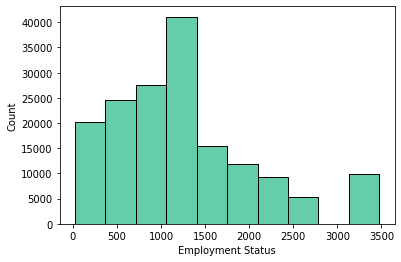

In [37]:
import matplotlib.pyplot as plt
plt.hist(temp["employment_status-population-unemployed_population_16_years_and_over"], edgecolor = "black", color = "mediumaquamarine")
plt.xlabel("Employment Status")
plt.ylabel("Count")

Text(0, 0.5, 'Funds')

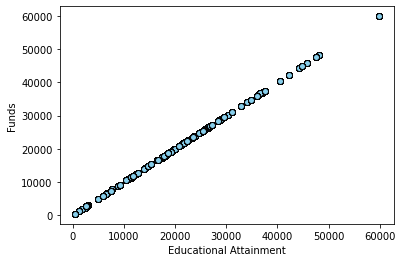

In [38]:
temp = tempDF.select("educational_attainment-population-population_25_years_and_over","CurrentApprovalAmount").toPandas()
plt.scatter(temp["educational_attainment-population-population_25_years_and_over"], temp["educational_attainment-population-population_25_years_and_over"], color='skyblue', marker="o", edgecolors="black")
plt.xlabel("Educational Attainment")
plt.ylabel("Funds")

## (8) Optional extra credit for +10 points. What are the Top 10 zipcodes that had the highest per capita amount of loans going to Women-Owned businesses?

This column is called `Gender` in the `PPP` data.

* What State are these zipcodes in? 
* Comment on if they have anything in common? 

In [39]:
wo_business = df.filter(F.col("Gender") == "Female Owned").select("BorrowerZip","BorrowerState","CurrentApprovalAmount","sex_and_age-population-total_population").groupBy("BorrowerZip","BorrowerState","sex_and_age-population-total_population").agg(sum("CurrentApprovalAmount").alias("Funds"))
wo_business = wo_business.withColumn("per_capita_funding", wo_business["Funds"]/wo_business["sex_and_age-population-total_population"])
zips = wo_business.sort(desc("per_capita_funding")).limit(10)
top10zips = [row[0] for row in zips.select("BorrowerZip").collect()]
print(top10zips)
print(zips.show())


['55111', '89402', '32461', '49434', '98238', '11556', '94104', '33122', '11931', '75247']
+-----------+-------------+---------------------------------------+--------------------+------------------+
|BorrowerZip|BorrowerState|sex_and_age-population-total_population|               Funds|per_capita_funding|
+-----------+-------------+---------------------------------------+--------------------+------------------+
|      55111|           MN|                                      4|            447569.0|         111892.25|
|      89402|           NV|                                     14|           1222479.0| 87319.92857142857|
|      32461|           FL|                                     21|           1313300.0| 62538.09523809524|
|      49434|           MI|                                     14|            600540.0| 42895.71428571428|
|      98238|           WA|                                     11|            457165.5|           41560.5|
|      11556|           NY|                  

# 🔴 Conclusion (5 pts)

## (1) What did you learn? 
Write five detailed bullets about what you learned. 

# On Your Own (no credit)
No points - but can you download ALL files for PPP data (several gigabytes of data) and re-run this script with ease? Post on the discussion board if you do!